### Some notes: 
- i saw that some user, item tuples of the random test set are present in the training set, is this ok?
- is negative subsampling of 200 items ok? i switched to 60 to keep the ration
- is K=4 and K=20 ok for recall?
- grid search for gamma=1.5 gives better results on Stratified with gamma=3, then by looking for the number of partitions that minimizes gamma=3

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import sys

# import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import numpy.random as npr
from scipy import sparse, stats

In [2]:
import numpy as np
from openrec.tf1.legacy import ImplicitModelTrainer
from openrec.tf1.legacy.utils.evaluators import ImplicitEvalManager
from openrec.tf1.legacy.utils import ImplicitDataset
from openrec.tf1.legacy.recommenders import CML, BPR, PMF
from openrec.tf1.legacy.utils.evaluators import AUC
from openrec.tf1.legacy.utils.samplers import PairwiseSampler
from tqdm.notebook import tqdm
import numpy as np
import math
import pandas as pd
import os
import pickle
import random

In [3]:
# Set the seed for reproducibility
seed = 2384795
np.random.seed(seed=seed)

# Preparing folder for output data
output_name = f"./generated_data/"
if os.path.exists(output_name) == False:
    os.makedirs(output_name)

In [4]:
DATA_DIR = './original_files/'

## Loading Datasets

In [5]:
raw_data = pd.read_csv(os.path.join(DATA_DIR, 'train.ascii'), sep=" ", header=None, engine="python")
test_data = pd.read_csv(os.path.join(DATA_DIR, 'test.ascii'), sep=" ", header=None, engine="python")

In [6]:
tr_vd_data = pd.DataFrame({"userId": sparse.coo_matrix(raw_data).row,                            "songId": sparse.coo_matrix(raw_data).col,                           "rating": sparse.coo_matrix(raw_data).data})

In [7]:
test_data = pd.DataFrame({"userId": sparse.coo_matrix(test_data).row,                            "songId": sparse.coo_matrix(test_data).col,                           "rating": sparse.coo_matrix(test_data).data})

## Defining functions

In [8]:
def split_train_test_proportion_old(data, uid, test_prop=0.5, random_seed=0):
    data_grouped_by_user = data.groupby(uid)
    tr_list, te_list = list(), list()

    np.random.seed(random_seed)

    for u, (_, group) in enumerate(data_grouped_by_user):
        n_items_u = len(group)

        if n_items_u >= 5:
            idx = np.zeros(n_items_u, dtype='bool')
            idx[np.random.choice(n_items_u, size=int(test_prop * n_items_u), replace=False).astype('int64')] = True

            tr_list.append(group[np.logical_not(idx)])
            te_list.append(group[idx])
        else:
            tr_list.append(group)

        if u % 5000 == 0:
            print("%d users sampled" % u)
            sys.stdout.flush()

    data_tr = pd.concat(tr_list)
    data_te = pd.concat(te_list)
    
    return data_tr, data_te

In [9]:
def split_train_test_proportion(data, random_seed=0):

    df_train = data

    # Create a test df
    df_test = pd.DataFrame(columns=data.columns)

    # Precompute, for each user, the list of songs with a relevant rating
    user_positive_ratings = data[data["rating"] == 1].groupby("user_id")["item_id"].apply(set)
    
    min_item, max_item = data['item_id'].min(), data['item_id'].max()

    # Initialize the range of indexes for the items
    items_ids = np.arange(min_item, max_item + 1)

    # Set the number of songs for each user
    SONGS_FOR_BIASED_TEST = 90

    users = set(data["user_id"].unique())

    # Extract the biased test set
    for user_id in users:

        # Get SONGS_FOR_BIASED_TEST items
        np.random.shuffle(items_ids)
        test_items = set(items_ids[-SONGS_FOR_BIASED_TEST:])

        # Get which are positive
        pos_ids = user_positive_ratings.get(user_id, set()) & test_items

        # Get which are negative but in test_items
        neg_ids = test_items - pos_ids

        # Set the positive ones to 0 in the training set (extract)
        df_train.loc[(df_train['item_id'].isin(pos_ids)) & (df_train['user_id'] == user_id), 'rating'] = 0

        # now add them in the test set
        # add to df_test the rows made of [user_id, pos_ids, 1] and [user_id, neg_ids, 0]
        for item_id in pos_ids:
            df_test = df_test.append({'user_id': user_id, 'item_id': item_id, 'rating': 1}, ignore_index=True)
        
        for item_id in neg_ids:
            df_test = df_test.append({'user_id': user_id, 'item_id': item_id, 'rating': 0}, ignore_index=True)

    # Convert back to the correct data types
    df_train['user_id'] = df_train['user_id'].astype(int)
    df_train['item_id'] = df_train['item_id'].astype(int)
    df_train['rating'] = df_train['rating'].astype(int)
    
    df_test['user_id'] = df_test['user_id'].astype(int)
    df_test['item_id'] = df_test['item_id'].astype(int)
    df_test['rating'] = df_test['rating'].astype(int)
    
    return df_train, df_test


In [10]:
def get_count(tp, id):
    playcount_groupbyid = tp[[id]].groupby(id, as_index=False)
    count = playcount_groupbyid.size()
    return count

## Make dataset implicit

In [11]:
tr_vd_data.head(10)

,userId,songId,rating
0,0,72,2
1,0,136,2
2,0,150,3
3,0,171,3
4,0,188,3
5,0,220,3
6,0,227,5
7,0,228,4
8,0,234,3
9,0,235,4


In [12]:
test_data.head(10)

,userId,songId,rating
0,0,12,4
1,0,17,3
2,0,74,4
3,0,78,2
4,0,92,2
5,0,104,4
6,0,127,4
7,0,128,3
8,0,133,3
9,0,145,2


In [13]:
# Suggested on the original yahoo's paper
POSITIVE_THRESHOLD = 4

# Add column to the DataFrame
tr_vd_data['ImplicitRating'] = np.where(tr_vd_data['rating'] >= POSITIVE_THRESHOLD, 1, 0)
test_data['ImplicitRating'] = np.where(test_data['rating'] >= POSITIVE_THRESHOLD, 1, 0)

In [14]:
tr_vd_data.head(10)

,userId,songId,rating,ImplicitRating
0,0,72,2,0
1,0,136,2,0
2,0,150,3,0
3,0,171,3,0
4,0,188,3,0
5,0,220,3,0
6,0,227,5,1
7,0,228,4,1
8,0,234,3,0
9,0,235,4,1


In [15]:
tr_vd_data = tr_vd_data.drop(['rating'],axis=1).rename({"ImplicitRating":"rating"}, axis='columns')

In [16]:
tr_vd_data.head(10)

,userId,songId,rating
0,0,72,0
1,0,136,0
2,0,150,0
3,0,171,0
4,0,188,0
5,0,220,0
6,0,227,1
7,0,228,1
8,0,234,0
9,0,235,1


In [17]:
test_data.head(10)

,userId,songId,rating,ImplicitRating
0,0,12,4,1
1,0,17,3,0
2,0,74,4,1
3,0,78,2,0
4,0,92,2,0
5,0,104,4,1
6,0,127,4,1
7,0,128,3,0
8,0,133,3,0
9,0,145,2,0


In [18]:
test_data = test_data.drop(['rating'],axis=1).rename({"ImplicitRating":"rating"}, axis='columns')

In [19]:
test_data.head(10)

,userId,songId,rating
0,0,12,1
1,0,17,0
2,0,74,1
3,0,78,0
4,0,92,0
5,0,104,1
6,0,127,1
7,0,128,0
8,0,133,0
9,0,145,0


In [21]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4640 entries, 0 to 4639
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   userId  4640 non-null   int32
 1   songId  4640 non-null   int32
 2   rating  4640 non-null   int64
dtypes: int32(2), int64(1)
memory usage: 72.6 KB


## Some stats

In [22]:
tr_vd_data.head(), tr_vd_data.shape

(   userId  songId  rating
 0       0      72       0
 1       0     136       0
 2       0     150       0
 3       0     171       0
 4       0     188       0,
 (6960, 3))

In [23]:
test_data.head(), test_data.shape

(   userId  songId  rating
 0       0      12       1
 1       0      17       0
 2       0      74       1
 3       0      78       0
 4       0      92       0,
 (4640, 3))

In [24]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4640 entries, 0 to 4639
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   userId  4640 non-null   int32
 1   songId  4640 non-null   int32
 2   rating  4640 non-null   int64
dtypes: int32(2), int64(1)
memory usage: 72.6 KB


In [25]:
user_activity = get_count(tr_vd_data, 'userId')
item_popularity = get_count(tr_vd_data, 'songId')

In [26]:
unique_uid = user_activity.index
unique_sid = item_popularity.index

In [27]:
n_users = len(unique_uid)
n_items = len(unique_sid)

In [28]:
n_users, n_items

(290, 300)

## Removing eventual songs and users from the test set not present in the training set

In [29]:
song2id = dict((sid, i) for (i, sid) in enumerate(unique_sid))
user2id = dict((uid, i) for (i, uid) in enumerate(unique_uid))

In [30]:
# for the test set, only keep the users/items from the training set

test_data = test_data.loc[test_data['userId'].isin(unique_uid)]
test_data = test_data.loc[test_data['songId'].isin(unique_sid)]

## Turn userId and songId to 0-based index

In [31]:
def numerize(tp):
    uid = list(map(lambda x: user2id[x], tp['userId']))
    sid = list(map(lambda x: song2id[x], tp['songId']))
    tp.loc[:, 'user_id'] = uid
    tp.loc[:, 'item_id'] = sid
    return tp[['user_id', 'item_id', 'rating']]

In [32]:
tr_vd_data = numerize(tr_vd_data)
test_data = numerize(test_data)

## Do we need the validation for our purpose?

In [33]:
#train_data, vad_data = split_train_test_proportion(tr_vd_data, 'user_id', test_prop=0.7, random_seed=12345)
#obs_test_data, vad_data = split_train_test_proportion(vad_data, 'user_id', test_prop=0.5, random_seed=12345)
train_data, obs_test_data = split_train_test_proportion(tr_vd_data, random_seed=12345)


In [34]:
print("There are total of %d unique users in the training set and %d unique users in the entire dataset" % (len(pd.unique(train_data['user_id'])), len(unique_uid)))

There are total of 290 unique users in the training set and 290 unique users in the entire dataset


In [35]:
print("There are total of %d unique items in the training set and %d unique items in the entire dataset" % (len(pd.unique(train_data['item_id'])), len(unique_sid)))

There are total of 300 unique items in the training set and 300 unique items in the entire dataset


In [36]:
def move_to_fill(part_data_1, part_data_2, unique_id, key):
    # move the data from part_data_2 to part_data_1 so that part_data_1 has the same number of unique "key" as unique_id
    part_id = set(pd.unique(part_data_1[key]))
    
    left_id = list()
    for i, _id in enumerate(unique_id):
        if _id not in part_id:
            left_id.append(_id)
            
    move_idx = part_data_2[key].isin(left_id)
    part_data_1 = part_data_1.append(part_data_2[move_idx])
    part_data_2 = part_data_2[~move_idx]
    return part_data_1, part_data_2

The move_to_fill function is used to ensure that train_data ends up with a complete set of unique IDs as specified by unique_id, by "moving" the necessary rows from another dataset (part_data_2 like vad_data or obs_test_data) and updating both DataFrames accordingly.

In [37]:
#train_data, vad_data = move_to_fill(train_data, vad_data, np.arange(n_items), 'item_id')
train_data, obs_test_data = move_to_fill(train_data, obs_test_data, np.arange(n_items), 'item_id')

In [38]:
print("There are total of %d unique items in the training set and %d unique items in the entire dataset" % (len(pd.unique(train_data['item_id'])), len(unique_sid)))

There are total of 300 unique items in the training set and 300 unique items in the entire dataset


## Store datasets in csv files

In [39]:
train_data.to_csv(os.path.join(output_name, 'train.csv'), index=False)
#vad_data.to_csv(os.path.join(output_name, 'validation.csv'), index=False)
tr_vd_data.to_csv(os.path.join(output_name, 'train_full.csv'), index=False)

In [40]:
obs_test_data.to_csv(os.path.join(output_name, 'obs_test_full.csv'), index=False)
test_data.to_csv(os.path.join(output_name, 'test_full.csv'), index=False)

now *obs_test_data* is our biased testset extracted by the original dataset, while *test_data* is our unbiased test set 

In [41]:
obs_test_data

,user_id,item_id,rating
0,0,298,1
1,0,251,1
2,0,228,1
3,0,236,1
4,0,257,0
...,...,...,...
26095,289,237,0
26096,289,239,0
26097,289,244,0
26098,289,249,0


## Build files for creating dataset for the openrec library

# Biased

In [42]:
# Init empty
pos_test_set = []
neg_test_set = []

In [43]:
# Create masks for positive and negative ratings
pos_mask = obs_test_data['rating'] == 1
neg_mask = obs_test_data['rating'] != 1

# Extract the user_id and item_id pairs for positive and negative ratings
pos_test_set = obs_test_data.loc[pos_mask, ['user_id', 'item_id']].values.tolist()
neg_test_set = obs_test_data.loc[neg_mask, ['user_id', 'item_id']].values.tolist()

# pos_test_set and neg_test_set now contain the lists of [user_id, item_id] for positive and negative ratings, respectively.
# Get np arrays
pos_test_set = np.array(pos_test_set)
neg_test_set = np.array(neg_test_set)

In [44]:
pos_test_set

array([[  0, 298],
       [  0, 251],
       [  0, 228],
       ...,
       [287, 138],
       [287, 120],
       [288,  36]])

In [45]:
# Get the dataframe
pos_test_set_df = pd.DataFrame(pos_test_set)
neg_test_set_df = pd.DataFrame(neg_test_set)

# Get couples user-item
pos_test_set_df.columns = ["user_id","item_id"]
neg_test_set_df.columns = ["user_id","item_id"]

# Turn into records
structured_data_pos_test_set = pos_test_set_df.to_records(index=False)
structured_data_neg_test_set = neg_test_set_df.to_records(index=False)

# Save
np.save(output_name + "biased-test_arr_pos.npy", structured_data_pos_test_set)
np.save(output_name + "biased-test_arr_neg.npy", structured_data_neg_test_set)

# Unbiased

In [46]:
# Init empty
pos_test_set = []
neg_test_set = []

In [47]:
# Create masks for positive and negative ratings
pos_mask = test_data['rating'] == 1
neg_mask = test_data['rating'] != 1

# Extract the user_id and item_id pairs for positive and negative ratings
pos_test_set = test_data.loc[pos_mask, ['user_id', 'item_id']].values.tolist()
neg_test_set = test_data.loc[neg_mask, ['user_id', 'item_id']].values.tolist()

# pos_test_set and neg_test_set now contain the lists of [user_id, item_id] for positive and negative ratings, respectively.
# Get np arrays
pos_test_set = np.array(pos_test_set)
neg_test_set = np.array(neg_test_set)

In [48]:
# Get the dataframe
pos_test_set_df = pd.DataFrame(pos_test_set)
neg_test_set_df = pd.DataFrame(neg_test_set)

# Get couples user-item
pos_test_set_df.columns = ["user_id","item_id"]
neg_test_set_df.columns = ["user_id","item_id"]

# Turn into records
structured_data_pos_test_set = pos_test_set_df.to_records(index=False)
structured_data_neg_test_set = neg_test_set_df.to_records(index=False)

# Save
np.save(output_name + "unbiased-test_arr_pos.npy", structured_data_pos_test_set)
np.save(output_name + "unbiased-test_arr_neg.npy", structured_data_neg_test_set)

# Trainset

In [49]:
positive_trainset = train_data[train_data['rating'] != 0]
positive_trainset = positive_trainset.drop(columns=['rating'])

# Convert the DataFrame to a structured array
positive_trainset = positive_trainset.to_records(index=False) 

# Save
np.save(output_name + "training_arr.npy", positive_trainset)

In [174]:
train_data["user_id"].unique().size, test_data["user_id"].unique().size, obs_test_data["user_id"].unique().size

(290, 290, 290)

In [51]:
positive_trainset["user_id"].unique().max(), test_data["user_id"].unique().max(), obs_test_data["user_id"].unique().max()

(289, 289, 289)

In [52]:
train_data["item_id"].unique().size, test_data["item_id"].unique().size, obs_test_data["item_id"].unique().size

(300, 300, 300)

In [53]:
train_data["item_id"].unique().max(), test_data["item_id"].unique().max(), obs_test_data["item_id"].unique().max()

(299, 299, 299)

# **MODEL CHOICE**

In [54]:
# Here I won't comment anything, we are just using the code provided by the authors of the paper

raw_data = dict()
raw_data['train_data'] = np.load(output_name + "training_arr.npy" )
raw_data['max_user'] = 290
raw_data['max_item'] = 300
batch_size = 8000
test_batch_size = 1000
display_itr = 1000

train_dataset = ImplicitDataset(raw_data['train_data'], raw_data['max_user'], raw_data['max_item'], name='Train')

MODEL_CLASS = CML
MODEL_PREFIX = "cml"
DATASET_NAME = "coat"
OUTPUT_FOLDER = output_name
OUTPUT_PATH = OUTPUT_FOLDER + MODEL_PREFIX + "-" + DATASET_NAME + "/"
OUTPUT_PREFIX = str(OUTPUT_PATH) + str(MODEL_PREFIX) + "-" + str(DATASET_NAME)


if os.path.exists(OUTPUT_PATH) == False:
    os.makedirs(OUTPUT_PATH)


In [55]:
# Prevent tensorflow from using cached embeddings
import tensorflow as tf
tf.compat.v1.reset_default_graph()

# Define the model
model = MODEL_CLASS(batch_size=batch_size, max_user=train_dataset.max_user(), max_item=train_dataset.max_item(), dim_embed=50, l2_reg=0.001, opt='Adam', sess_config=None)
sampler = PairwiseSampler(batch_size=batch_size, dataset=train_dataset, num_process=4)
model_trainer = ImplicitModelTrainer(batch_size=batch_size, test_batch_size=test_batch_size, train_dataset=train_dataset, model=model, sampler=sampler, eval_save_prefix=OUTPUT_PATH + DATASET_NAME, item_serving_size=500)
auc_evaluator = AUC()

# Train the model
model_trainer.train(num_itr=10001, display_itr=display_itr)

# Save in the output folder
model.save(OUTPUT_PATH,None)

# Delete the model from the memory
del model


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
keep_dims is deprecated, use keepdims instead

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where






2024-08-19 16:42:49.303013: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2024-08-19 16:42:49.328104: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f8f6f414310 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2024-08-19 16:42:49.328120: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


== Start training with FULL evaluation ==
[Itr 100] Finished
[Itr 200] Finished
[Itr 300] Finished
[Itr 400] Finished
[Itr 500] Finished
[Itr 600] Finished
[Itr 700] Finished
[Itr 800] Finished
[Itr 900] Finished
[Itr 1000] Finished
INFO:tensorflow:./generated_data/cml-coat/coat-1000 is not in all_model_checkpoint_paths. Manually adding it.
[Itr 1000] loss: 6817.881247
[Itr 1100] Finished
[Itr 1200] Finished
[Itr 1300] Finished
[Itr 1400] Finished
[Itr 1500] Finished
[Itr 1600] Finished
[Itr 1700] Finished
[Itr 1800] Finished
[Itr 1900] Finished
[Itr 2000] Finished
INFO:tensorflow:./generated_data/cml-coat/coat-2000 is not in all_model_checkpoint_paths. Manually adding it.
[Itr 2000] loss: 6674.632245
[Itr 2100] Finished
[Itr 2200] Finished
[Itr 2300] Finished
[Itr 2400] Finished
[Itr 2500] Finished
[Itr 2600] Finished
[Itr 2700] Finished
[Itr 2800] Finished
[Itr 2900] Finished
[Itr 3000] Finished
INFO:tensorflow:./generated_data/cml-coat/coat-3000 is not in all_model_checkpoint_paths.

# **DEFINING FUNCTIONS**

In [217]:
def calculate_propensities(n_users, n_items, trainfilename, gammas=[1.5, 2, 2.5, 3], normalize=True):

    Ni = dict()
    propensities = dict()

    # Compute frequencies of items in the training set
    trainset = np.load(trainfilename)
    for i in trainset['item_id']:
        if i in Ni:
            Ni[i] += 1
        else:
            Ni[i] = 1

    for gamma in gammas:
        propensities[gamma] = np.empty((n_users,n_items))

    for theitem in range(n_items):
        if theitem not in Ni:
            continue
        for gamma in gammas:
            propensities[gamma][:,theitem] = np.power(Ni[theitem], (gamma + 1) / 2.0)

    if normalize:
        for gamma in gammas:
            propensities[gamma] /= propensities[gamma].max()

    return propensities
    

In [56]:
def eq(infilename, infilename_neg, trainfilename, gamma=-1.0, K=4):

    # Read pickles
    infile = open(infilename, 'rb')
    infile_neg = open(infilename_neg, 'rb')
    P = pickle.load(infile)
    infile.close()
    P_neg = pickle.load(infile_neg)
    infile_neg.close()
    NUM_NEGATIVES = P["num_negatives"]
    
    # Merge P and P_neg
    for theuser in P["users"]:
        neg_items = list(P_neg["user_items"][theuser][NUM_NEGATIVES:])
        neg_scores = list(P_neg["results"][theuser][NUM_NEGATIVES:])
        P["user_items"][theuser] = list(neg_items) + list(P["user_items"][theuser][NUM_NEGATIVES:])
        P["results"][theuser] = list(neg_scores) + list(P["results"][theuser][NUM_NEGATIVES:])
    
    Zui = dict()
    Ni = dict()
    
    # Compute frequencies of items in the training set
    trainset = np.load(trainfilename)
    for i in trainset['item_id']:
        if i in Ni:
            Ni[i] += 1
        else:
            Ni[i] = 1
    del trainset

    # Count #users with non-zero item frequencies
    nonzero_user_count = 0
    for theuser in P["users"]:
        pos_items = P["user_items"][theuser][len(P_neg["user_items"][theuser][NUM_NEGATIVES:]):]
        for pos_item in pos_items:
            if pos_item in Ni:
                nonzero_user_count += 1
                break
    
    # Compute recommendations for each user
    for theuser in P["users"]:
        all_scores = np.array(P["results"][theuser])
        pos_items = P["user_items"][theuser][len(P_neg["user_items"][theuser][NUM_NEGATIVES:]):]
        pos_scores = P["results"][theuser][len(P_neg["results"][theuser][NUM_NEGATIVES:]):]
        for i, pos_item in enumerate(pos_items):
            pos_score = pos_scores[i]
            Zui[(theuser, pos_item)] = float(np.sum(all_scores > pos_score))

    
    # Calculate per-user scores
    sum_user_auc = 0.0
    sum_user_recall = 0.0
    for theuser in P["users"]:
        numerator_auc = 0.0
        numerator_recall = 0.0
        denominator = 0.0

        for theitem in P["user_items"][theuser][len(P_neg["user_items"][theuser][NUM_NEGATIVES:]):]:
            if theitem not in Ni:
                continue
            pui = np.power(Ni[theitem], (gamma + 1) / 2.0)

            numerator_auc += (1 - Zui[(theuser, theitem)] / len(P["user_items"][theuser])) / pui
            
            if Zui[(theuser, theitem)] < K:
                numerator_recall += 1.0 / pui
            denominator += 1 / pui
                
        if denominator > 0:
            sum_user_auc += numerator_auc / denominator
            sum_user_recall += numerator_recall / denominator 

    # Return
    return {
        "auc"       : sum_user_auc / nonzero_user_count,
        "recall"    : sum_user_recall / nonzero_user_count,
        "bias"      : -1,
        "concentration" : -1
    }

In [57]:
def aoa(infilename, infilename_neg, trainfilename, K=4):

    # Read pickles
    infile = open(infilename, 'rb')
    infile_neg = open(infilename_neg, 'rb')
    P = pickle.load(infile)
    infile.close()
    P_neg = pickle.load(infile_neg)
    infile_neg.close()
    NUM_NEGATIVES = P["num_negatives"]
    
    # Merge P and P_neg
    for theuser in P["users"]:
        neg_items = list(P_neg["user_items"][theuser][NUM_NEGATIVES:])
        neg_scores = list(P_neg["results"][theuser][NUM_NEGATIVES:])
        P["user_items"][theuser] = list(neg_items) + list(P["user_items"][theuser][NUM_NEGATIVES:])
        P["results"][theuser] = list(neg_scores) + list(P["results"][theuser][NUM_NEGATIVES:])
    
    Zui = dict()
    Ni = dict()

    # Compute frequencies of items in the training set
    trainset = np.load(trainfilename)
    for i in trainset['item_id']:
        if i in Ni:
            Ni[i] += 1
        else:
            Ni[i] = 1
    del trainset
    
    # Count #users with non-zero item frequencies
    nonzero_user_count = 0
    for theuser in P["users"]:
        pos_items = P["user_items"][theuser][len(P_neg["user_items"][theuser][NUM_NEGATIVES:]):]
        for pos_item in pos_items:
            if pos_item in Ni:
                nonzero_user_count += 1
                break
    
    # Compute recommendations for each user
    for theuser in P["users"]:
        all_scores = np.array(P["results"][theuser])
        pos_items = P["user_items"][theuser][len(P_neg["user_items"][theuser][NUM_NEGATIVES:]):]
        pos_scores = P["results"][theuser][len(P_neg["results"][theuser][NUM_NEGATIVES:]):]
        for i, pos_item in enumerate(pos_items):
            pos_score = pos_scores[i]
            Zui[(theuser, pos_item)] = float(np.sum(all_scores > pos_score))

    # Calculate per-user scores
    sum_user_auc = 0.0
    sum_user_recall = 0.0
    for theuser in P["users"]:
        numerator_auc = 0.0
        numerator_recall = 0.0
        denominator = 0.0

        for theitem in P["user_items"][theuser][len(P_neg["user_items"][theuser][NUM_NEGATIVES:]):]:
            if theitem not in Ni:
                continue
            numerator_auc += (1 - Zui[(theuser, theitem)] / len(P["user_items"][theuser]))
            # Calcolo il Recall a 30, vedi nota 6 paper
            if Zui[(theuser, theitem)] < K:
                numerator_recall += 1.0
            denominator += 1 

        if denominator > 0:
            sum_user_auc += numerator_auc / denominator
            sum_user_recall += numerator_recall / denominator

    # Return
    return {
        "auc"       : sum_user_auc / nonzero_user_count,
        "recall"    : sum_user_recall / nonzero_user_count,
        "bias"      : -1,
        "concentration" : -1
    }

In [58]:
def stratified(infilename, infilename_neg, trainfilename, gamma=1.0, K=20, partition=10, delta=0.1):

    # Read pickles
    infile = open(infilename, 'rb')
    infile_neg = open(infilename_neg, 'rb')
    P = pickle.load(infile)
    infile.close()
    P_neg = pickle.load(infile_neg)
    infile_neg.close()
    NUM_NEGATIVES = P["num_negatives"]

    # Merge P and P_neg
    for theuser in P["users"]:
        neg_items = list(P_neg["user_items"][theuser][NUM_NEGATIVES:])
        neg_scores = list(P_neg["results"][theuser][NUM_NEGATIVES:])
        P["user_items"][theuser] = list(neg_items) + list(P["user_items"][theuser][NUM_NEGATIVES:])
        P["results"][theuser] = list(neg_scores) + list(P["results"][theuser][NUM_NEGATIVES:])

    Zui = dict()
    Ni = dict()

    # Compute frequencies of items in the training set
    trainset = np.load(trainfilename)
    for i in trainset['item_id']:
        if i in Ni:
            Ni[i] += 1
        else:
            Ni[i] = 1

    # Compute recommendations for each user
    for theuser in P["users"]:
        all_scores = np.array(P["results"][theuser])
        pos_items = P["user_items"][theuser][len(P_neg["user_items"][theuser][NUM_NEGATIVES:]):]
        pos_scores = P["results"][theuser][len(P_neg["results"][theuser][NUM_NEGATIVES:]):]
        for i, pos_item in enumerate(pos_items):
            pos_score = pos_scores[i]
            Zui[(theuser, pos_item)] = float(np.sum(all_scores > pos_score))

    pui = dict()
    w = dict()

    # Compute dictionary of propensity scores
    for theuser in P["users"]:
        for theitem in P["user_items"][theuser][len(P_neg["user_items"][theuser][NUM_NEGATIVES:]):]:
            if theitem not in Ni:
                continue
            if theitem in pui:
                continue
            pui[theitem] = np.power(Ni[theitem], (gamma + 1) / 2.0)

    # Take the list of items (not tuples) in pui sorted by value
    items_sorted_by_value = sorted(pui, key=pui.get, reverse=True)

    # Compute linspace between the pui[0] and pui[-1] 
    linspace = np.linspace(pui[items_sorted_by_value[0]], pui[items_sorted_by_value[-1]], partition+1)
   
    # Compute dictionary w, that is, for each item, assigns the average of the puis in the partition it belongs to
    i=0
    j = 0
    while i < len(items_sorted_by_value):
                            
        avg = 0
        start = i
        end = i
    
        while i < len(items_sorted_by_value) and pui[items_sorted_by_value[i]] >= linspace[j+1]:
            avg += 1.0 / pui[items_sorted_by_value[i]]
            end = i
            i += 1
        avg = avg / (end - start + 1)

        for k in range(start, end+1):
            w[items_sorted_by_value[k]] = avg

        j += 1

    # Compute bias' numerator
    bias = 0.0
    for k in pui.keys():
        # add |pui*w - 1!|
        bias += abs(pui[k] * w[k] - 1)
    # Multiply by number of users
    bias *= len(P["users"])

    # Compute concentrations numerator (for each user)
    concentrations = {}
    max_w = max(w.values())
    # ... by computing the sum of squares of w for each user
    for user, item in zip(trainset['user_id'], trainset['item_id']):
        # Iterate over the trainset to compute the sum of squares for each user
        if item in w:
            if user not in concentrations:
                concentrations[user] = 0
            concentrations[user] += w[item] ** 2
    # ... and then applying the formula
    for user in concentrations:
        concentrations[user] = math.sqrt(concentrations[user] * 2 * math.log(2/delta)) + max_w * 7 * math.log(2/delta)
    # Now sum all the concentrations
    concentration = sum(concentrations.values())

    # Calculate per-user scores
    nonzero_user_count = 0
    sum_user_auc = 0.0
    sum_user_recall = 0.0
    for theuser in P["users"]:
        numerator_auc = 0.0
        numerator_recall = 0.0
        denominator = 0.0
        for theitem in P["user_items"][theuser][len(P_neg["user_items"][theuser][NUM_NEGATIVES:]):]:
            # Skip items with null frequency
            if  theitem not in Ni:
                continue
            # Add things to be summed for each item
            numerator_auc += (1 - Zui[(theuser, theitem)] / len(P["user_items"][theuser])) * w[theitem]
            # Add things for recall
            if Zui[(theuser, theitem)] < K:
                numerator_recall += 1.0 * w[theitem] # spetta
            # Increment denominator that the sum must be divided by 
            denominator += 1 / pui[theitem]


        # If there was at least one item for the user, count the user and sum the results
        if denominator > 0:
            nonzero_user_count += 1
            sum_user_auc += numerator_auc / denominator
            sum_user_recall += numerator_recall / denominator 

    # Return
    return {
        "auc"       : sum_user_auc / nonzero_user_count, 
        "recall"    : sum_user_recall / nonzero_user_count,
        "bias"      : bias,
        "concentration" : concentration
    }

In [59]:
def stratified_logspace(infilename, infilename_neg, trainfilename, gamma=1.0, K=20, partition=10, delta=0.1):

    # Read pickles
    infile = open(infilename, 'rb')
    infile_neg = open(infilename_neg, 'rb')
    P = pickle.load(infile)
    infile.close()
    P_neg = pickle.load(infile_neg)
    infile_neg.close()
    NUM_NEGATIVES = P["num_negatives"]

    # Merge P and P_neg
    for theuser in P["users"]:
        neg_items = list(P_neg["user_items"][theuser][NUM_NEGATIVES:])
        neg_scores = list(P_neg["results"][theuser][NUM_NEGATIVES:])
        P["user_items"][theuser] = list(neg_items) + list(P["user_items"][theuser][NUM_NEGATIVES:])
        P["results"][theuser] = list(neg_scores) + list(P["results"][theuser][NUM_NEGATIVES:])

    Zui = dict()
    Ni = dict()

    # Compute frequencies of items in the training set
    trainset = np.load(trainfilename)
    for i in trainset['item_id']:
        if i in Ni:
            Ni[i] += 1
        else:
            Ni[i] = 1

    # Compute recommendations for each user
    for theuser in P["users"]:
        all_scores = np.array(P["results"][theuser])
        pos_items = P["user_items"][theuser][len(P_neg["user_items"][theuser][NUM_NEGATIVES:]):]
        pos_scores = P["results"][theuser][len(P_neg["results"][theuser][NUM_NEGATIVES:]):]
        for i, pos_item in enumerate(pos_items):
            pos_score = pos_scores[i]
            Zui[(theuser, pos_item)] = float(np.sum(all_scores > pos_score))

    pui = dict()
    w = dict()

    # Compute dictionary of propensity scores
    for theuser in P["users"]:
        for theitem in P["user_items"][theuser][len(P_neg["user_items"][theuser][NUM_NEGATIVES:]):]:
            if theitem not in Ni:
                continue
            if theitem in pui:
                continue
            pui[theitem] = np.power(Ni[theitem], (gamma + 1) / 2.0)

    # Take the list of items (not tuples) in pui sorted by value
    items_sorted_by_value = sorted(pui, key=pui.get, reverse=True)

    # Compute linspace between the pui[0] and pui[-1] 

    # Maybe try to split the logspace instead of the linspace?
    logspace = np.logspace(pui[items_sorted_by_value[0]], pui[items_sorted_by_value[-1]], partition+1)
   
    # Compute dictionary w, that is, for each item, assigns the average of the puis in the partition it belongs to
    i=0
    j = 0
    while i < len(items_sorted_by_value):
                            
        avg = 0
        start = i
        end = i
    
        while i < len(items_sorted_by_value) and pui[items_sorted_by_value[i]] >= logspace[j+1]:
            avg += 1.0 / pui[items_sorted_by_value[i]]
            end = i
            i += 1
        
        # Is the average the only good choice? even with the log space split?
        avg = avg / (end - start + 1)

        for k in range(start, end+1):
            w[items_sorted_by_value[k]] = avg

        j += 1

        # Compute bias' numerator
        bias = 0.0
        for k in pui.keys():
            # add |pui*w - 1!|
            bias += abs(pui[k] * w[k] - 1)
        # Multiply by number of users
        bias *= len(P["users"])

        # Compute concentrations numerator (for each user)
        concentrations = {}
        max_w = max(w.values())
        # ... by computing the sum of squares of w for each user
        for user, item in zip(trainset['user_id'], trainset['item_id']):
            # Iterate over the trainset to compute the sum of squares for each user
            if item in w:
                if user not in concentrations:
                    concentrations[user] = 0
                concentrations[user] += w[item] ** 2
        # ... and then applying the formula
        for user in concentrations:
            concentrations[user] = math.sqrt(concentrations[user] * 2 * math.log(2/delta)) + max_w * 7 * math.log(2/delta)
        # Now sum all the concentrations
        concentration = sum(concentrations.values())

    # Compute score with AUC and compute Recall
    nonzero_user_count = 0
    sum_user_auc = 0.0
    sum_user_recall = 0.0
    for theuser in P["users"]:
        numerator_auc = 0.0
        numerator_recall = 0.0
        denominator = 0.0
        for theitem in P["user_items"][theuser][len(P_neg["user_items"][theuser][NUM_NEGATIVES:]):]:
            # Skip items with null frequency
            if  theitem not in Ni:
                continue
            # Add things to be summed for each item
            numerator_auc += (1 - Zui[(theuser, theitem)] / len(P["user_items"][theuser])) * w[theitem]
            # Add things for recall
            if Zui[(theuser, theitem)] < K:
                numerator_recall += 1.0 * w[theitem] # spetta
            # Increment denominator that the sum must be divided by 
            denominator += 1 / pui[theitem]


        # If there was at least one item for the user, count the user and sum the results
        if denominator > 0:
            nonzero_user_count += 1
            sum_user_auc += numerator_auc / denominator
            sum_user_recall += numerator_recall / denominator 

    # Return
    return {
        "auc"       : sum_user_auc / nonzero_user_count, 
        "recall"    : sum_user_recall / nonzero_user_count,
        "bias"      : bias,
        "concentration" : concentration
    }

In [60]:
# This version uses the linspace of the number of number of items used for evaluation, not of the propensities
def stratified_2(infilename, infilename_neg, trainfilename, gamma=1.0, K=20, partition=10, delta=0.1):

    # Read pickles
    infile = open(infilename, 'rb')
    infile_neg = open(infilename_neg, 'rb')
    P = pickle.load(infile)
    infile.close()
    P_neg = pickle.load(infile_neg)
    infile_neg.close()
    NUM_NEGATIVES = P["num_negatives"]

    # Merge P and P_neg
    for theuser in P["users"]:
        neg_items = list(P_neg["user_items"][theuser][NUM_NEGATIVES:])
        neg_scores = list(P_neg["results"][theuser][NUM_NEGATIVES:])
        P["user_items"][theuser] = list(neg_items) + list(P["user_items"][theuser][NUM_NEGATIVES:])
        P["results"][theuser] = list(neg_scores) + list(P["results"][theuser][NUM_NEGATIVES:])

    Zui = dict()
    Ni = dict()

    # Compute frequencies of items in the training set
    trainset = np.load(trainfilename)
    for i in trainset['item_id']:
        if i in Ni:
            Ni[i] += 1
        else:
            Ni[i] = 1

    # Compute recommendations for each user
    for theuser in P["users"]:
        all_scores = np.array(P["results"][theuser])
        pos_items = P["user_items"][theuser][len(P_neg["user_items"][theuser][NUM_NEGATIVES:]):]
        pos_scores = P["results"][theuser][len(P_neg["results"][theuser][NUM_NEGATIVES:]):]
        for i, pos_item in enumerate(pos_items):
            pos_score = pos_scores[i]
            Zui[(theuser, pos_item)] = float(np.sum(all_scores > pos_score))

    pui = dict()
    w = dict()

    # Compute dictionary of propensity scores
    for theuser in P["users"]:
        for theitem in P["user_items"][theuser][len(P_neg["user_items"][theuser][NUM_NEGATIVES:]):]:
            if theitem not in Ni:
                continue
            if theitem in pui:
                continue
            pui[theitem] = np.power(Ni[theitem], (gamma + 1) / 2.0)

    # Take the list of items (not tuples) in pui sorted by value
    items_sorted_by_value = sorted(pui, key=pui.get, reverse=True)

    # Compute linspace between the 0 to len(item_sorted...)
    linspace = np.linspace(0, len(items_sorted_by_value), partition+1)
   
    # Compute dictionary w, that is, for each item, assigns the average of the puis in the partition it belongs to
    i=0
    j = 0
    while i < len(items_sorted_by_value):
                            
        avg = 0
        start = i
        end = i
    
        while i < len(items_sorted_by_value) and i < linspace[j+1]:
            avg += 1.0 / pui[items_sorted_by_value[i]]
            end = i
            i += 1
        
        avg = avg / (end - start + 1)

        for k in range(start, end+1):
            w[items_sorted_by_value[k]] = avg

        j += 1

    # Compute bias' numerator
    bias = 0.0
    for k in pui.keys():
        # add |pui*w - 1!|
        bias += abs(pui[k] * w[k] - 1)
    # Multiply by number of users
    bias *= len(P["users"])

    # Compute concentrations numerator (for each user)
    concentrations = {}
    max_w = max(w.values())
    # ... by computing the sum of squares of w for each user
    for user, item in zip(trainset['user_id'], trainset['item_id']):
        # Iterate over the trainset to compute the sum of squares for each user
        if item in w:
            if user not in concentrations:
                concentrations[user] = 0
            concentrations[user] += w[item] ** 2
    # ... and then applying the formula
    for user in concentrations:
        concentrations[user] = math.sqrt(concentrations[user] * 2 * math.log(2/delta)) + max_w * 7 * math.log(2/delta)
    # Now sum all the concentrations
    concentration = sum(concentrations.values())

    # Compute score with AUC and compute Recall
    nonzero_user_count = 0
    sum_user_auc = 0.0
    sum_user_recall = 0.0
    for theuser in P["users"]:
        numerator_auc = 0.0
        numerator_recall = 0.0
        denominator = 0.0
        for theitem in P["user_items"][theuser][len(P_neg["user_items"][theuser][NUM_NEGATIVES:]):]:
            # Skip items with null frequency
            if  theitem not in Ni:
                continue
            # Add things to be summed for each item
            numerator_auc += (1 - Zui[(theuser, theitem)] / len(P["user_items"][theuser])) * w[theitem]
            # Add things for recall
            if Zui[(theuser, theitem)] < K:
                numerator_recall += 1.0 * w[theitem] # spetta
            # Increment denominator that the sum must be divided by 
            denominator += 1 / pui[theitem]


        # If there was at least one item for the user, count the user and sum the results
        if denominator > 0:
            nonzero_user_count += 1
            sum_user_auc += numerator_auc / denominator
            sum_user_recall += numerator_recall / denominator 

    return {
        "auc"       : sum_user_auc / nonzero_user_count, 
        "recall"    : sum_user_recall / nonzero_user_count,
        "bias"      : bias,
        "concentration" : concentration
    }

# **EVALUATION**

In [61]:
# Load data
raw_data = dict()
raw_data['train_data'] = np.load(output_name + "training_arr.npy")
raw_data['test_data_pos_biased'] = np.load(output_name + "biased-test_arr_pos.npy")
raw_data['test_data_neg_biased'] = np.load(output_name + "biased-test_arr_neg.npy")
raw_data['test_data_pos_unbiased'] = np.load(output_name + "unbiased-test_arr_pos.npy")
raw_data['test_data_neg_unbiased'] = np.load(output_name + "unbiased-test_arr_neg.npy")
raw_data['max_user'] = 290
raw_data['max_item'] = 300
batch_size = 8000
test_batch_size = 1000
display_itr = 1000

# Load data
train_dataset = ImplicitDataset(raw_data['train_data'], raw_data['max_user'], raw_data['max_item'], name='Train')
test_dataset_pos_biased = ImplicitDataset(raw_data['test_data_pos_biased'], raw_data['max_user'], raw_data['max_item'])
test_dataset_neg_biased = ImplicitDataset(raw_data['test_data_neg_biased'], raw_data['max_user'], raw_data['max_item'])
test_dataset_pos_unbiased = ImplicitDataset(raw_data['test_data_pos_unbiased'], raw_data['max_user'], raw_data['max_item'])
test_dataset_neg_unbiased = ImplicitDataset(raw_data['test_data_neg_unbiased'], raw_data['max_user'], raw_data['max_item'])

In [62]:
# Prevent tensorflow from using cached embeddings
import tensorflow as tf
tf.compat.v1.reset_default_graph()

# Define the model
model = MODEL_CLASS(batch_size=batch_size, max_user=train_dataset.max_user(), max_item=train_dataset.max_item(), dim_embed=50, l2_reg=0.001, opt='Adam', sess_config=None)
sampler = PairwiseSampler(batch_size=batch_size, dataset=train_dataset, num_process=4)
model_trainer = ImplicitModelTrainer(batch_size=batch_size, test_batch_size=test_batch_size, train_dataset=train_dataset, model=model, sampler=sampler, eval_save_prefix=OUTPUT_PATH + DATASET_NAME, item_serving_size=500)
auc_evaluator = AUC()

# Load model
model.load(OUTPUT_PATH)

# Set parameters
model_trainer._eval_manager = ImplicitEvalManager(evaluators=[auc_evaluator])
model_trainer._num_negatives = 60 # in yahoo they were 200 on 1000 items, so let's keep a 1/5 ratio on 300 items
model_trainer._exclude_positives([train_dataset, test_dataset_pos_biased, test_dataset_neg_biased])
model_trainer._sample_negatives(seed=10)

INFO:tensorflow:Restoring parameters from ./generated_data/cml-coat/
[Subsampling negative items]


## Biased Evaluation

In [63]:
model_trainer._eval_save_prefix = OUTPUT_PREFIX + "-test-pos-biased"
model_trainer._evaluate_partial(test_dataset_pos_biased)

model_trainer._eval_save_prefix = OUTPUT_PREFIX +  "-test-neg-biased"
model_trainer._evaluate_partial(test_dataset_neg_biased)

100%|██████████| 290/290 [00:01<00:00, 270.18it/s]


{'AUC': [0.5265503875968993,
  0.5900749063670412,
  0.44356060606060604,
  0.45378787878787885,
  0.47659176029962536,
  0.5618773946360153,
  0.4011363636363636,
  0.5239700374531835,
  0.500766283524904,
  0.5718390804597702,
  0.5188888888888888,
  0.4957364341085272,
  0.5272222222222223,
  0.5503745318352059,
  0.5527777777777778,
  0.5543071161048688,
  0.507962962962963,
  0.4275280898876404,
  0.4767045454545455,
  0.48183520599250934,
  0.5218992248062017,
  0.5155038759689923,
  0.5100000000000001,
  0.48033707865168546,
  0.46329365079365076,
  0.42827715355805246,
  0.45191570881226056,
  0.48689138576779023,
  0.548689138576779,
  0.5335205992509363,
  0.5372549019607844,
  0.5235955056179775,
  0.5003787878787879,
  0.5196296296296297,
  0.5271535580524345,
  0.5096590909090909,
  0.5965909090909092,
  0.416851851851852,
  0.581992337164751,
  0.4886274509803921,
  0.4691011235955056,
  0.5051136363636364,
  0.5034883720930233,
  0.3691011235955056,
  0.5220973782771535,

## Unbiased Evaluation

In [64]:
model_trainer._eval_save_prefix = OUTPUT_PREFIX + "-test-pos-unbiased"
model_trainer._evaluate_partial(test_dataset_pos_unbiased)

model_trainer._eval_save_prefix = OUTPUT_PREFIX +  "-test-neg-unbiased"
model_trainer._evaluate_partial(test_dataset_neg_unbiased)

100%|██████████| 290/290 [00:00<00:00, 936.06it/s]


{'AUC': [0.5533333333333333,
  0.5357142857142858,
  0.6000000000000001,
  0.49102564102564106,
  0.4243589743589744,
  0.5988095238095238,
  0.4744444444444445,
  0.49583333333333335,
  0.42500000000000004,
  0.4948717948717949,
  0.4358974358974359,
  0.42833333333333323,
  0.5190476190476191,
  0.5666666666666667,
  0.4844444444444444,
  0.6369047619047619,
  0.5208333333333334,
  0.3178571428571429,
  0.5750000000000001,
  0.6100000000000001,
  0.5155555555555555,
  0.5361111111111111,
  0.32291666666666663,
  0.6083333333333333,
  0.49090909090909085,
  0.40238095238095234,
  0.5870370370370371,
  0.5144444444444444,
  0.5928571428571429,
  0.4714285714285714,
  0.4272727272727273,
  0.5178571428571429,
  0.4644444444444444,
  0.5212121212121213,
  0.5047619047619046,
  0.46481481481481485,
  0.5680555555555556,
  0.4395833333333333,
  0.44000000000000006,
  0.39,
  0.3208333333333333,
  0.4782051282051282,
  0.5911111111111113,
  0.5255555555555556,
  0.5266666666666667,
  0.5322

## Calculate Propensities

In [219]:
propensities = calculate_propensities(290,300, output_name+"training_arr.npy")


In [220]:
propensities[1.5]

array([[1.        , 0.        , 0.09453009, ..., 0.19708824, 0.04991823,
        0.04991823],
       [1.        , 0.        , 0.09453009, ..., 0.19708824, 0.04991823,
        0.04991823],
       [1.        , 0.        , 0.09453009, ..., 0.19708824, 0.04991823,
        0.04991823],
       ...,
       [1.        , 0.        , 0.09453009, ..., 0.19708824, 0.04991823,
        0.04991823],
       [1.        , 0.        , 0.09453009, ..., 0.19708824, 0.04991823,
        0.04991823],
       [1.        , 0.        , 0.09453009, ..., 0.19708824, 0.04991823,
        0.04991823]])

## Calculate Metrics

Compute AOA and unbiased evaluator metrics with biased testset.

In [109]:
biased_results = dict()

# biased_results["STRATIFIED_15"] = stratified(OUTPUT_PREFIX+"-test-pos-biased_evaluate_partial.pickle", OUTPUT_PREFIX+"-test-neg-biased_evaluate_partial.pickle", output_name+"training_arr.npy", gamma=1.5, K=20, partition=100)
biased_results["AOA"] = aoa(OUTPUT_PREFIX+"-test-pos-biased_evaluate_partial.pickle", OUTPUT_PREFIX+"-test-neg-biased_evaluate_partial.pickle", output_name+"training_arr.npy", K=20)
biased_results["UB_15"] = eq(OUTPUT_PREFIX+"-test-pos-biased_evaluate_partial.pickle", OUTPUT_PREFIX+"-test-neg-biased_evaluate_partial.pickle", output_name+"training_arr.npy", gamma=1.5, K=20)
biased_results["UB_2"] =  eq(OUTPUT_PREFIX+"-test-pos-biased_evaluate_partial.pickle", OUTPUT_PREFIX+"-test-neg-biased_evaluate_partial.pickle", output_name+"training_arr.npy", gamma=2, K=20)
biased_results["UB_25"] =  eq(OUTPUT_PREFIX+"-test-pos-biased_evaluate_partial.pickle", OUTPUT_PREFIX+"-test-neg-biased_evaluate_partial.pickle", output_name+"training_arr.npy", gamma=2.5, K=20)
biased_results["UB_3"] =  eq(OUTPUT_PREFIX+"-test-pos-biased_evaluate_partial.pickle", OUTPUT_PREFIX+"-test-neg-biased_evaluate_partial.pickle", output_name+"training_arr.npy", gamma=3, K=20)

Compute AOA and unbiased evaluator metrics with unbiased testset.

In [110]:
unbiased_results = dict()

# unbiased_results["STRATIFIED_15"] = stratified(OUTPUT_PREFIX+"-test-pos-unbiased_evaluate_partial.pickle", OUTPUT_PREFIX+"-test-neg-unbiased_evaluate_partial.pickle", output_name+"training_arr.npy", gamma=1.5, K=4, partition=100)
unbiased_results["AOA"] = aoa(OUTPUT_PREFIX+"-test-pos-unbiased_evaluate_partial.pickle", OUTPUT_PREFIX+"-test-neg-unbiased_evaluate_partial.pickle", output_name+"training_arr.npy", K=4)
unbiased_results["UB_15"] = eq(OUTPUT_PREFIX+"-test-pos-unbiased_evaluate_partial.pickle", OUTPUT_PREFIX+"-test-neg-unbiased_evaluate_partial.pickle", output_name+"training_arr.npy", gamma=1.5, K=4)
unbiased_results["UB_2"] =  eq(OUTPUT_PREFIX+"-test-pos-unbiased_evaluate_partial.pickle", OUTPUT_PREFIX+"-test-neg-unbiased_evaluate_partial.pickle", output_name+"training_arr.npy", gamma=2, K=4)
unbiased_results["UB_25"] =  eq(OUTPUT_PREFIX+"-test-pos-unbiased_evaluate_partial.pickle", OUTPUT_PREFIX+"-test-neg-unbiased_evaluate_partial.pickle", output_name+"training_arr.npy", gamma=2.5, K=4)
unbiased_results["UB_3"] =  eq(OUTPUT_PREFIX+"-test-pos-unbiased_evaluate_partial.pickle", OUTPUT_PREFIX+"-test-neg-unbiased_evaluate_partial.pickle", output_name+"training_arr.npy", gamma=3, K=4)

Get partitions.

In [111]:
# Get number of items
num_items = 300

# Get the n_p partitions
n_p = 300
nums = np.arange(1, num_items+1)
partitions = np.random.choice(nums, n_p, replace=False)

# Visualize
partitions

array([192, 274,  62,  90, 150, 228, 162, 184, 249, 126,  95, 288, 163,
       117,  26, 205, 171, 214, 210,  49, 236, 168, 276,  38, 189, 250,
       123, 299,  67, 277, 278, 283, 222, 141, 176, 213,  94, 231, 110,
        93, 134,  81,  20, 257, 137, 208, 161, 287,  68, 140, 127, 291,
         8, 146, 155, 202,  40, 174,  45, 198, 139, 217, 203,  87, 247,
        66,  76, 120, 193, 170, 221,  27, 116, 285, 215,  88,  72, 275,
         7,  24, 240,  84, 122, 248, 220,  11, 166, 252, 244, 261,  69,
       279, 263,  60, 280, 233, 230,  59, 100, 177,  77, 169,  46,  33,
        61,  41, 253,  39, 282, 284,  98,  82,  96, 154, 188, 207, 256,
        17, 136, 129, 152,  10, 199, 183, 260,  97,  16,  15,  80,  12,
        34,  28, 224, 156,  53, 209, 294, 245, 235, 179,  14, 219,  65,
       106,  50,  13, 178,  48, 242,  23, 153, 149, 112, 218, 238, 147,
        47, 225, 157, 124,  89,  74,  56, 237, 115,   3, 138,  52, 119,
       243, 111,  57,  54,  86, 298, 107, 158, 216, 196, 258,   

Compute the partition which minimizes the sum of AUC and Recall

In [127]:
# Compute biased and unbiased results with stratified for each partition
# and store biased and unbiased results such that the sum of AUC and Recall is minimized

# Value of gamma to use for minimization
gamma = 1.5

# To print :)
key = "STRATIFIED_" + str(gamma).replace(".","")

# Initialize results
unbiased_results[key] = dict()
biased_results[key] = dict()
best_partition = np.random.choice(nums, 1)[0]

history = np.empty(300)


# For each partition
for p in tqdm(partitions):
    # Compute the results (AUC and Recall) for both biased and unbiased test sets
    temp_unbiased = stratified(OUTPUT_PREFIX+"-test-pos-unbiased_evaluate_partial.pickle", OUTPUT_PREFIX+"-test-neg-unbiased_evaluate_partial.pickle", output_name+"training_arr.npy", gamma=gamma, K=4, partition=p)
    temp_biased = stratified(OUTPUT_PREFIX+"-test-pos-biased_evaluate_partial.pickle", OUTPUT_PREFIX+"-test-neg-biased_evaluate_partial.pickle", output_name+"training_arr.npy", gamma=gamma, K=20, partition=p)
    # If first iteration...
    if not unbiased_results[key]:
        unbiased_results[key] = temp_unbiased
    if not biased_results[key]:
        biased_results[key] = temp_biased
    # Else if a better partition was found, update the results
    elif temp_unbiased['bias'] + temp_unbiased['concentration'] + temp_biased['bias'] + temp_biased['concentration'] < biased_results[key]['bias'] + biased_results[key]['concentration'] + unbiased_results[key]['bias'] + unbiased_results[key]['concentration']:
        biased_results[key]['auc'] = temp_biased['auc']
        biased_results[key]['recall'] = temp_biased['recall']
        biased_results[key]['bias'] = temp_biased['bias']
        biased_results[key]['concentration'] = temp_biased['concentration']
        unbiased_results[key]['auc'] = temp_unbiased['auc']
        unbiased_results[key]['recall'] = temp_unbiased['recall']
        biased_results[key]['bias'] = temp_biased['bias']
        biased_results[key]['concentration'] = temp_biased['concentration']
        best_partition = p
    #print(temp_unbiased['bias'], temp_biased['bias'], temp_unbiased['concentration'], temp_biased['concentration'])
    history[p-1] = temp_unbiased['bias'] + temp_unbiased['concentration'] + temp_biased['bias'] + temp_biased['concentration']

  0%|          | 0/300 [00:00<?, ?it/s]

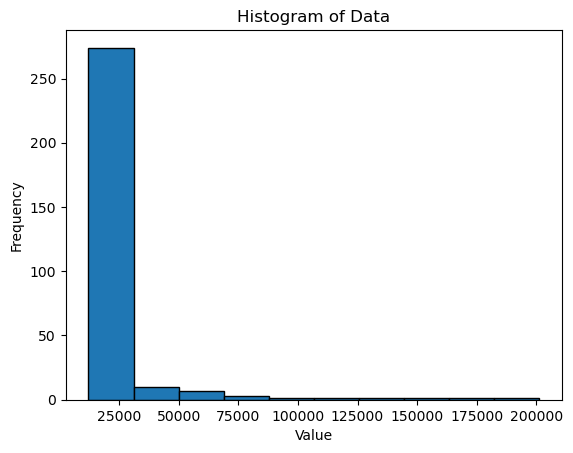

In [129]:
import matplotlib.pyplot as plt

# Plotting the histogram
plt.hist(history, bins=10, edgecolor='black')

# Adding labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Data')

# Display the plot
plt.show()

So, for the chosen value of gamma, the best partition is...

In [130]:
# Visualize
best_partition

199

Compute stratified metrics with unbiased testset.

In [131]:
unbiased_results["STRATIFIED_15"] = stratified(OUTPUT_PREFIX+"-test-pos-unbiased_evaluate_partial.pickle", OUTPUT_PREFIX+"-test-neg-unbiased_evaluate_partial.pickle", output_name+"training_arr.npy", gamma=1.5, K=4, partition=best_partition)
biased_results["STRATIFIED_15"] = stratified(OUTPUT_PREFIX+"-test-pos-biased_evaluate_partial.pickle", OUTPUT_PREFIX+"-test-neg-biased_evaluate_partial.pickle", output_name+"training_arr.npy", gamma=1.5, K=20, partition=best_partition)

unbiased_results["STRATIFIED_2"] = stratified(OUTPUT_PREFIX+"-test-pos-unbiased_evaluate_partial.pickle", OUTPUT_PREFIX+"-test-neg-unbiased_evaluate_partial.pickle", output_name+"training_arr.npy", gamma=2, K=4, partition=best_partition)
biased_results["STRATIFIED_2"] = stratified(OUTPUT_PREFIX+"-test-pos-biased_evaluate_partial.pickle", OUTPUT_PREFIX+"-test-neg-biased_evaluate_partial.pickle", output_name+"training_arr.npy", gamma=2, K=20, partition=best_partition)

unbiased_results["STRATIFIED_25"] = stratified(OUTPUT_PREFIX+"-test-pos-unbiased_evaluate_partial.pickle", OUTPUT_PREFIX+"-test-neg-unbiased_evaluate_partial.pickle", output_name+"training_arr.npy", gamma=2.5, K=4, partition=best_partition)
biased_results["STRATIFIED_25"] = stratified(OUTPUT_PREFIX+"-test-pos-biased_evaluate_partial.pickle", OUTPUT_PREFIX+"-test-neg-biased_evaluate_partial.pickle", output_name+"training_arr.npy", gamma=2.5, K=20, partition=best_partition)

unbiased_results["STRATIFIED_3"] = stratified(OUTPUT_PREFIX+"-test-pos-unbiased_evaluate_partial.pickle", OUTPUT_PREFIX+"-test-neg-unbiased_evaluate_partial.pickle", output_name+"training_arr.npy", gamma=3, K=4, partition=best_partition)
biased_results["STRATIFIED_3"] = stratified(OUTPUT_PREFIX+"-test-pos-biased_evaluate_partial.pickle", OUTPUT_PREFIX+"-test-neg-biased_evaluate_partial.pickle", output_name+"training_arr.npy", gamma=3, K=20, partition=best_partition)


This version uses the linspace of items instead of linspace of propensities to make the partition.

In [132]:
unbiased_results["STRATIFIED_v2_15"] = stratified_2(OUTPUT_PREFIX+"-test-pos-unbiased_evaluate_partial.pickle", OUTPUT_PREFIX+"-test-neg-unbiased_evaluate_partial.pickle", output_name+"training_arr.npy", gamma=1.5, K=4, partition=best_partition)
biased_results["STRATIFIED_v2_15"] = stratified_2(OUTPUT_PREFIX+"-test-pos-biased_evaluate_partial.pickle", OUTPUT_PREFIX+"-test-neg-biased_evaluate_partial.pickle", output_name+"training_arr.npy", gamma=1.5, K=20, partition=best_partition)

unbiased_results["STRATIFIED_v2_2"] = stratified_2(OUTPUT_PREFIX+"-test-pos-unbiased_evaluate_partial.pickle", OUTPUT_PREFIX+"-test-neg-unbiased_evaluate_partial.pickle", output_name+"training_arr.npy", gamma=2, K=4, partition=best_partition)
biased_results["STRATIFIED_v2_2"] = stratified_2(OUTPUT_PREFIX+"-test-pos-biased_evaluate_partial.pickle", OUTPUT_PREFIX+"-test-neg-biased_evaluate_partial.pickle", output_name+"training_arr.npy", gamma=2, K=20, partition=best_partition)

unbiased_results["STRATIFIED_v2_25"] = stratified_2(OUTPUT_PREFIX+"-test-pos-unbiased_evaluate_partial.pickle", OUTPUT_PREFIX+"-test-neg-unbiased_evaluate_partial.pickle", output_name+"training_arr.npy", gamma=2.5, K=4, partition=best_partition)
biased_results["STRATIFIED_v2_25"] = stratified_2(OUTPUT_PREFIX+"-test-pos-biased_evaluate_partial.pickle", OUTPUT_PREFIX+"-test-neg-biased_evaluate_partial.pickle", output_name+"training_arr.npy", gamma=2.5, K=20, partition=best_partition)

unbiased_results["STRATIFIED_v2_3"] = stratified_2(OUTPUT_PREFIX+"-test-pos-unbiased_evaluate_partial.pickle", OUTPUT_PREFIX+"-test-neg-unbiased_evaluate_partial.pickle", output_name+"training_arr.npy", gamma=3, K=4, partition=best_partition)
biased_results["STRATIFIED_v2_3"] = stratified_2(OUTPUT_PREFIX+"-test-pos-biased_evaluate_partial.pickle", OUTPUT_PREFIX+"-test-neg-biased_evaluate_partial.pickle", output_name+"training_arr.npy", gamma=3, K=20, partition=best_partition)

In [133]:
rows = 0
columns = len(biased_results.keys())

for key in biased_results.keys():
    rows = max(rows, len(biased_results[key].keys()))

for key in unbiased_results.keys():
    rows = max(rows, len(biased_results[key].keys()))

rows, columns

(4, 13)

In [134]:
# Init dictionary
mae_results = dict()

# Get the names of the rows
list_biased_res = list(biased_results.keys())


# Init results
results_array = np.zeros((rows,columns))

Fill the table with the MAE results.

In [135]:
# For each row
for i in range(len(list_biased_res)):
    key = list_biased_res[i]

    # For each column
    for j in range(len(list(biased_results[key].keys()))):
        key_2 = list(biased_results[key].keys())[j]

        # Compute MAE
        results_array[j][i] = abs(biased_results[key][key_2] - unbiased_results[key][key_2])

# Make it a DataFrame
mae_df = pd.DataFrame(columns=list(biased_results.keys()), data=results_array)
metric_values = list(biased_results[list(biased_results.keys())[0]].keys())
mae_df.insert(0, "metric", metric_values)

# **RESULTS**

In [136]:
# Visualize
mae_df.head()

,metric,AOA,UB_15,UB_2,UB_25,UB_3,STRATIFIED_15,STRATIFIED_2,STRATIFIED_25,STRATIFIED_3,STRATIFIED_v2_15,STRATIFIED_v2_2,STRATIFIED_v2_25,STRATIFIED_v2_3
0,auc,0.054800,0.090975,0.095139,0.098290,0.100626,9.097485e-02,9.513882e-02,9.828963e-02,0.072265,0.089552,0.093386,0.096192,0.098169
1,recall,0.076203,0.113201,0.117820,0.121511,0.124447,1.132014e-01,1.178203e-01,1.215106e-01,0.133113,0.112005,0.116341,0.119731,0.122350
2,bias,0.000000,0.000000,0.000000,0.000000,0.000000,1.082268e-11,7.539636e-12,4.317213e-12,5425.714286,143.909688,173.446281,203.398273,233.838054
3,concentration,0.000000,0.000000,0.000000,0.000000,0.000000,1.294130e+02,1.265924e+02,1.243931e+02,231.346606,129.427445,126.599289,124.396269,122.635240
